# Oral Cancer Classification

## Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd


import cv2
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
import os
data = "data"
categories = os.listdir(data)
print("Categories found:", categories)

Categories found: ['oral_normal', 'oral_scc']


In [3]:
image_counts = {}
total_images = 0

for subclass in os.listdir(data):
    subclass_path = os.path.join(data, subclass)
    if os.path.isdir(subclass_path):
        num_images = len([
            f for f in os.listdir(subclass_path)
            if os.path.isfile(os.path.join(subclass_path, f))
        ])
        image_counts[subclass] = num_images
        total_images += num_images

print("Image counts in ALL subclasses:")
for subclass, count in image_counts.items():
    print(f"{subclass}: {count}")
print(f"\nTotal images in ALL: {total_images}")

Image counts in ALL subclasses:
oral_normal: 5001
oral_scc: 5001

Total images in ALL: 10002


In [4]:
X = []
y = []

img_size = 128  # You can increase to 150 or 224 later if your system can handle it

for label, category in enumerate(categories):
    folder_path = os.path.join(data, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


In [5]:
# Convert to NumPy arrays
from tensorflow.keras.utils import to_categorical

X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0

y = np.array(y)
y = to_categorical(y, num_classes=len(categories))

# Feedback and confirmation
print("✅ Data preprocessing complete!")
print(f"Shape of X: {X.shape}")  # e.g., (15000, 128, 128, 1)
print(f"Shape of y: {y.shape}")  # e.g., (15000, 3)

✅ Data preprocessing complete!
Shape of X: (10002, 128, 128, 1)
Shape of y: (10002, 2)


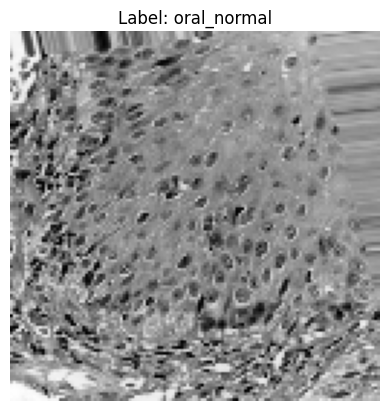

In [6]:
# Preview an example image and its label
index = 0
plt.imshow(X[index].reshape(img_size, img_size), cmap='gray')
plt.title(f"Label: {categories[np.argmax(y[index])]}")
plt.axis('off')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data split complete!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

✅ Data split complete!
Training samples: 8001
Testing samples: 2001


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(categories), activation='softmax')
])

c:\Users\revna\Desktop\Colab Projects\Cancer_Classification\can_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test)
)

c:\Users\revna\Desktop\Colab Projects\Cancer_Classification\can_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 215ms/step - accuracy: 0.4994 - loss: 0.7227 - val_accuracy: 0.5447 - val_loss: 0.7032
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 119s 475ms/step - accuracy: 0.5696 - loss: 0.6782 - val_accuracy: 0.5562 - val_loss: 0.6737
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.6051 - loss: 0.6598 - val_accuracy: 0.5577 - val_loss: 0.6894
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step - accuracy: 0.6307 - loss: 0.6394 - val_accuracy: 0.6282 - val_loss: 0.6515
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step - accuracy: 0.6294 - loss: 0.6435 - val_accuracy: 0.6257 - val_loss: 0.6439
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 181ms/step - accuracy: 0.6283 - loss: 0.6399 - val_accuracy: 0.6387 - val_loss: 0.6266
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.6478 - loss: 0.6271 - val_accuracy: 0.6477 - val_loss: 0.6307
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.6363 - loss: 

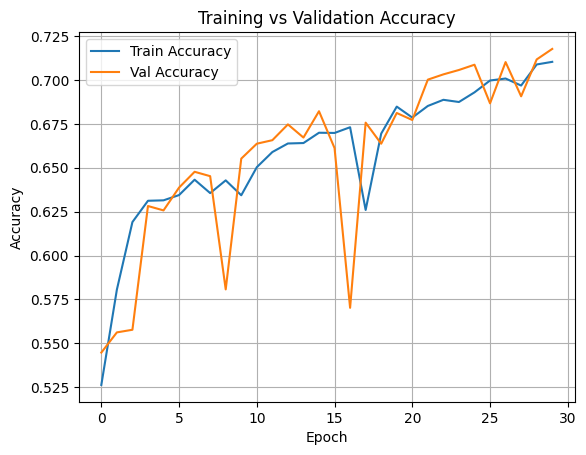

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np

# Get predicted probabilities and class labels
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step


In [14]:
print("📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))
print("✅ Accuracy Score:", accuracy_score(y_true, y_pred_classes))
try:
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f"ROC-AUC Score: {auc:.4f}")
except Exception as e:
    print("Could not compute AUC:", e)

📊 Classification Report:
              precision    recall  f1-score   support

 oral_normal       0.67      0.87      0.75      1000
    oral_scc       0.81      0.57      0.67      1001

    accuracy                           0.72      2001
   macro avg       0.74      0.72      0.71      2001
weighted avg       0.74      0.72      0.71      2001

✅ Accuracy Score: 0.7176411794102948
ROC-AUC Score: 0.8241
